<a href="https://colab.research.google.com/github/asmaaabdelsattar/instant-training/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pandas numpy tensorflow scikit-learn matplotlib seaborn

In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:

train_df = pd.read_csv("/content/drive/MyDrive/sentiment_analysis/twitter_training.csv", names=["id", "entity", "label", "text"])
val_df = pd.read_csv("/content/drive/MyDrive/sentiment_analysis/twitter_validation.csv", names=["id", "entity", "label", "text"])

print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)
train_df.head()


Training set shape: (74682, 4)
Validation set shape: (1000, 4)


,id,entity,label,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [31]:
# Keep only Positive, Negative, Neutral labels
valid_labels = ['Positive', 'Negative', 'Neutral']

train_df = train_df[train_df['label'].isin(valid_labels)]
val_df = val_df[val_df['label'].isin(valid_labels)]

print("Remaining classes:", train_df['label'].unique())
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Remaining classes: ['Positive' 'Neutral' 'Negative']
Train samples: 61692
Validation samples: 828


In [32]:
# Drop rows with missing text or label values
train_df.dropna(subset=['text', 'label'], inplace=True)
val_df.dropna(subset=['text', 'label'], inplace=True)

# Show how many samples remain
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))



Training samples: 61121
Validation samples: 828


In [33]:
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])
val_df['label_enc'] = le.transform(val_df['label'])

y_train = to_categorical(train_df['label_enc'])
y_val = to_categorical(val_df['label_enc'])


In [34]:
MAX_WORDS = 10000    # how many unique words to keep
MAX_SEQ_LEN = 50     # maximum sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

# Convert texts to sequences of word indices
X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['text'])

# Pad/truncate sequences to have equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')


In [35]:
# Convert integer labels to one-hot encoded format
y_train = to_categorical(train_df['label_enc'])
y_val = to_categorical(val_df['label_enc'])

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


y_train shape: (61121, 3)
y_val shape: (828, 3)


In [36]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

MAX_WORDS = 10000
EMBEDDING_DIM = 128
MAX_SEQ_LEN = 50

model = Sequential([
    Input(shape=(MAX_SEQ_LEN,)),                # explicitly give input shape
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,035 (5.42 MB)

 Trainable params: 1,420,035 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 184s 188ms/step - accuracy: 0.3633 - loss: 1.0937 - val_accuracy: 0.4553 - val_loss: 1.0433
Epoch 2/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 205s 191ms/step - accuracy: 0.5149 - loss: 0.9809 - val_accuracy: 0.8237 - val_loss: 0.5008
Epoch 3/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 183s 192ms/step - accuracy: 0.8007 - loss: 0.5263 - val_accuracy: 0.9287 - val_loss: 0.2256
Epoch 4/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 182s 190ms/step - accuracy: 0.8785 - loss: 0.3272 - val_accuracy: 0.9505 - val_loss: 0.1784
Epoch 5/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 206s 195ms/step - accuracy: 0.9128 - loss: 0.2322 - val_accuracy: 0.9481 - val_loss: 0.1803
Epoch 6/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 200s 209ms/step - accuracy: 0.9316 - loss: 0.1799 - val_accuracy: 0.9505 - val_loss: 0.1915
Epoch 7/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 182s 191ms/step - accuracy: 0.9409 - loss: 0.1502 - val_accuracy: 0.9589 - val_loss: 0.1773
Epoch 8/10
956/956 ━━━━━━━━━━━━━━━━━━━━ 177s 185ms/step - accuracy: 0.9496 -

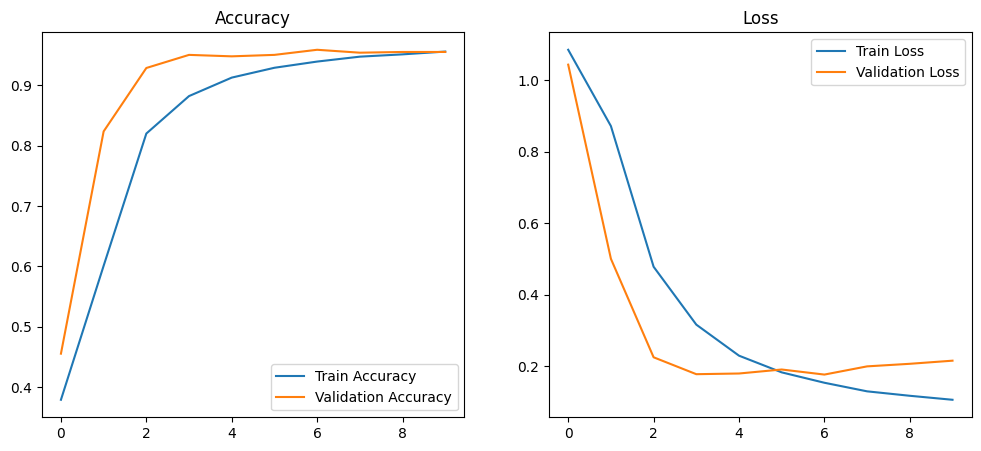

In [38]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [45]:
import numpy as np

# Manually redefine your label encoder mapping
label_encoder.classes_ = np.array(['Negative', 'Neutral', 'Positive'])

# Now decode predictions
pred_labels = label_encoder.inverse_transform(pred_classes)

for text, label in zip(texts, pred_labels):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {label}")
    print("-" * 40)


Text: I love this product! It works perfectly.
Predicted Sentiment: Positive
----------------------------------------
Text: This is terrible, I'm very disappointed.
Predicted Sentiment: Negative
----------------------------------------
Text: It's okay, nothing special.
Predicted Sentiment: Neutral
----------------------------------------


In [46]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define the same max length used during training
MAX_SEQ_LEN = 50  # same as used before

# Example texts to test
texts = [
    "I love this product! It works perfectly.",
    "This is terrible, I'm very disappointed.",
    "It's okay, nothing special."
]

# Convert to sequences using the same tokenizer
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
X_test_custom = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# Predict
pred_probs = model.predict(X_test_custom)
pred_classes = np.argmax(pred_probs, axis=1)

# Decode predictions
pred_labels = label_encoder.inverse_transform(pred_classes)

for text, label in zip(texts, pred_labels):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {label}")
    print("-" * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: I love this product! It works perfectly.
Predicted Sentiment: Positive
----------------------------------------
Text: This is terrible, I'm very disappointed.
Predicted Sentiment: Negative
----------------------------------------
Text: It's okay, nothing special.
Predicted Sentiment: Neutral
----------------------------------------


In [47]:
import joblib

# Save model
model.save("sentiment_lstm_model.h5")

# Save tokenizer
joblib.dump(tokenizer, "tokenizer.pkl")

# Save label encoder
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [48]:
from google.colab import files

files.download("sentiment_lstm_model.h5")
files.download("tokenizer.pkl")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
model = load_model("sentiment_lstm_model.h5")

# Save a clean version without optimizer state
model.save("sentiment_lstm_model_inference.h5", include_optimizer=False)
print("✅ Model saved as sentiment_lstm_model_inference.h5")

✅ Model saved as sentiment_lstm_model_inference.h5


In [57]:
from google.colab import files
files.download("sentiment_lstm_model_inference.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>